In [1]:
%load_ext tensorboard

import shutil
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.metrics import functional as FM

Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
                 It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe


D:\conda\envs\lightning\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('seaborn-pastel')
# mpl.rcParams['axes.facecolor'] = 'white'
# mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#f38181', '#fce38a', '#95e1d3']) 

In [3]:
# https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(7)
np.random.seed(7)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## LightningDataModule (Fashion MNIST)

In [4]:
class MNISTDataset(pl.LightningDataModule):
    def __init__(self, root_dir, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.root_dir = root_dir
        self.transforms = transforms.Compose([transforms.ToTensor()])
        
    def prepare_data(self):
        self.train_ds = torchvision.datasets.FashionMNIST(
            self.root_dir, train=True, transform=self.transforms, download=True)
        
    def setup(self, stage=None):
        val_len = int(0.2 * len(self.train_ds))
        train_len = len(self.train_ds) - val_len
        self.train_ds, self.val_ds = torch.utils.data.random_split(
            self.train_ds, [train_len, val_len],
            generator=torch.Generator().manual_seed(7))
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        test_ds = torchvision.datasets.FashionMNIST(
            self.root_dir, train=False, transform=self.transforms, download=True)
        loader = torch.utils.data.DataLoader(dataset=test_ds, batch_size=self.batch_size, shuffle=False)
        return loader

## LightningModule (LeNet classifier)

In [5]:
class LitClassifier(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.lr = 2e-3
        
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        # Get the number of features in a batch of tensors `x`.
        size = x.size()[1:]
        return np.prod(size)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        acc = FM.accuracy(y_hat, y)
        loss = F.cross_entropy(y_hat, y)
        
        result = pl.TrainResult(loss)
        result.log_dict({'train_acc': acc, 'train_loss': loss}, on_step=True, on_epoch=False)
        return result

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        
        val_acc = FM.accuracy(y_hat, y)
        val_loss = F.cross_entropy(y_hat, y)
        
        result = pl.EvalResult()
        result.log_dict({'val_acc': val_acc, 'val_loss': val_loss}, reduce_fx=torch.mean)
#         result.log('val/epoch_end_metric', y_hat, on_step=False, on_epoch=True, prog_bar=True, reduce_fx=torch.mean)
        return result


    def test_step(self, batch, batch_idx):
        result = self.validation_step(batch, batch_idx)
        result.rename_keys({'val_acc': 'test_acc', 'val_loss': 'test_loss'})
        return result

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Tensorboard

In [6]:
try:
    shutil.rmtree('logs/')
except FileNotFoundError:
    pass

In [7]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 11324), started 2:38:33 ago. (Use '!kill 11324' to kill it.)

In [8]:
num_epochs = 5
batch_size = 64
root_dir = 'data/'

In [9]:
## 1e-5

In [10]:
model = LitClassifier()
dataset = MNISTDataset(root_dir, batch_size)
logger  = TensorBoardLogger(save_dir='logs/1e-5')
trainer = pl.Trainer(gpus=1, max_epochs=num_epochs, logger=logger, auto_lr_find=False, val_check_interval=0.5)

model.lr = 1e-5

print(f'Default model LR: {model.lr}')

trainer.fit(model, dataset);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Default model LR: 1e-05


D:\conda\envs\lightning\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 156   
1 | conv2 | Conv2d | 2 K   
2 | fc1   | Linear | 48 K  
3 | fc2   | Linear | 10 K  
4 | fc3   | Linear | 850   


D:\conda\envs\lightning\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: RuntimeWarning: The metric you returned None must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of loss in validation_epoch_end()?
  warnings.warn(*args, **kwargs)
D:\conda\envs\lightning\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: RuntimeWarning: Can save best model only with loss available, skipping.
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..


## 1e-4

In [11]:
model = LitClassifier()
dataset = MNISTDataset(root_dir, batch_size)
logger  = TensorBoardLogger(save_dir='logs/1e-4')
trainer = pl.Trainer(gpus=1, max_epochs=num_epochs, logger=logger, auto_lr_find=False, val_check_interval=0.5)

model.lr = 1e-4

print(f'Default model LR: {model.lr}')

trainer.fit(model, dataset);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 156   
1 | conv2 | Conv2d | 2 K   
2 | fc1   | Linear | 48 K  
3 | fc2   | Linear | 10 K  
4 | fc3   | Linear | 850   


Default model LR: 0.0001


Saving latest checkpoint..


In [12]:
## 1e-1

In [13]:
model = LitClassifier()
dataset = MNISTDataset(root_dir, batch_size)
logger  = TensorBoardLogger(save_dir='logs/1e-1')
trainer = pl.Trainer(gpus=1, max_epochs=num_epochs, logger=logger, auto_lr_find=False, val_check_interval=50)

model.lr = 1e-1

print(f'Default model LR: {model.lr}')

trainer.fit(model, dataset);

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 156   
1 | conv2 | Conv2d | 2 K   
2 | fc1   | Linear | 48 K  
3 | fc2   | Linear | 10 K  
4 | fc3   | Linear | 850   


Default model LR: 0.1


Saving latest checkpoint..


In [14]:
# trainer.test(model, ckpt_path='best', verbose=True, datamodule=dataset)

## find_lr

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 156   
1 | conv2 | Conv2d | 2 K   
2 | fc1   | Linear | 48 K  
3 | fc2   | Linear | 10 K  
4 | fc3   | Linear | 850   


Saving latest checkpoint..

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 156   
1 | conv2 | Conv2d | 2 K   
2 | fc1   | Linear | 48 K  
3 | fc2   | Linear | 10 K  
4 | fc3   | Linear | 850   


Auto-find model LR: 0.036307805477010104


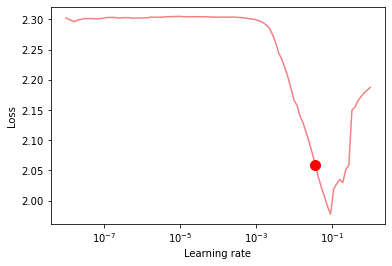

In [15]:
# del model
# del trainer
# del dataset

# model = LitClassifier()
# trainer = get_trainer(logs_dir='logs/find_lr')
# dataset = FashionMNISTDataset(root_dir='data/')

model = LitClassifier(batch_size)
dataset = MNISTDataset(root_dir, batch_size)
logger  = TensorBoardLogger(save_dir='logs/find_lr')
trainer = pl.Trainer(gpus=1, max_epochs=num_epochs, logger=logger, auto_lr_find=False, val_check_interval=0.5)

lr_finder = trainer.lr_find(model, dataset)
model.hparams.lr = lr_finder.suggestion()
print(f'Auto-find model LR: {model.hparams.lr}')

fig = lr_finder.plot(suggest=True)

trainer.fit(model, dataset);

In [16]:
fig.show()

<ipython-input-16-6ebedab27258>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [17]:
# trainer.test(model, ckpt_path='best', verbose=True, datamodule=dataset)

In [18]:
# trainer

# > <pytorch_lightning.trainer.trainer.Trainer at 0x1b886c29d90>

In [19]:
# lr_finder = trainer.tuner.lr_find(model, dataset)

# > AttributeError: 'Trainer' object has no attribute 'tuner'

In [20]:
# model.lr = lr_finder.suggestion()
# model.lr